<div align="center"> 

# **"TTE Conversion from R to Python (TTE-v1)"**

</div>

<div align="justify"> 

### **Python Library Imports**

</div>

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import PerfectSeparationError
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from typing import Optional, List, Dict, Union
from sklearn.metrics import accuracy_score
from dataclasses import dataclass
from pathlib import Path

<div align="justify"> 

### <span style="color:rgb(255, 123, 0);">**Step 1: Setup:**</span>
</div>

In [2]:
# Step 1: Specify the estimand
trial_pp = {"estimand": "PP"}  # Per-protocol
trial_itt = {"estimand": "ITT"}  # Intention-to-treat

# Step 2: Define the base directory as "./Dataset"
base_dir = "../Datasets"

# Step 3: Create directories to save files
trial_pp_dir = os.path.join(base_dir, "trial_pp")
trial_itt_dir = os.path.join(base_dir, "trial_itt")

# Create the directories (including the base directory if it doesn't exist)
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

# Print the paths for verification
print(f"Per-Protocol (PP) directory: {trial_pp_dir}")
print(f"Intention-to-Treat (ITT) directory: {trial_itt_dir}")

Per-Protocol (PP) directory: ../Datasets\trial_pp
Intention-to-Treat (ITT) directory: ../Datasets\trial_itt


### <span style="color:rgb(255, 123, 0);">**Step 2: Data Preparation**</span>

In [3]:
# Step 1: Load the dataset from "../Dataset/data_censored.csv"
dataset_path = "../Datasets/data_censored.csv"
data_censored = pd.read_csv(dataset_path)

# Display the first few rows of the dataset
print("Loaded Dataset:")
print(data_censored.head())

# Step 2: Define a function to set data for analysis
def set_data(trial, data, id_col, period_col, treatment_col, outcome_col, eligible_col):
    """
    Configures the trial object with the specified dataset and columns.
    """
    trial['data'] = data
    trial['id'] = id_col
    trial['period'] = period_col
    trial['treatment'] = treatment_col
    trial['outcome'] = outcome_col
    trial['eligible'] = eligible_col
    return trial

# Step 3: Configure trial_pp (Per-Protocol)
trial_pp = {}
trial_pp = set_data(
    trial_pp,
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

# Step 4: Configure trial_itt (Intention-to-Treat)
trial_itt = {}
trial_itt = set_data(
    trial_itt,
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

# Step 5: Print the configured trial objects
print("\nPer-Protocol (PP) Trial:")
print(trial_pp)

print("\nIntention-to-Treat (ITT) Trial:")
print(trial_itt)

Loaded Dataset:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

Per-Protocol (PP) Trial:
{'data':      id  period  treatment  x1        x2  x3        x4  age     age_s  \
0     1       0          1   1  1.146148   0  0.734203   36  0.083333   
1     1       1          1   1  0.002200   0  0.734203   37  0.166667   
2     1       2          1   0 -0.481762   0  0.734203   38  0.250000   
3     1       3          1   0  

##### <span style="color:rgb(0, 207, 121);">**Miscellaneuous: Visualizing the Initialized Dictionaries**</span>

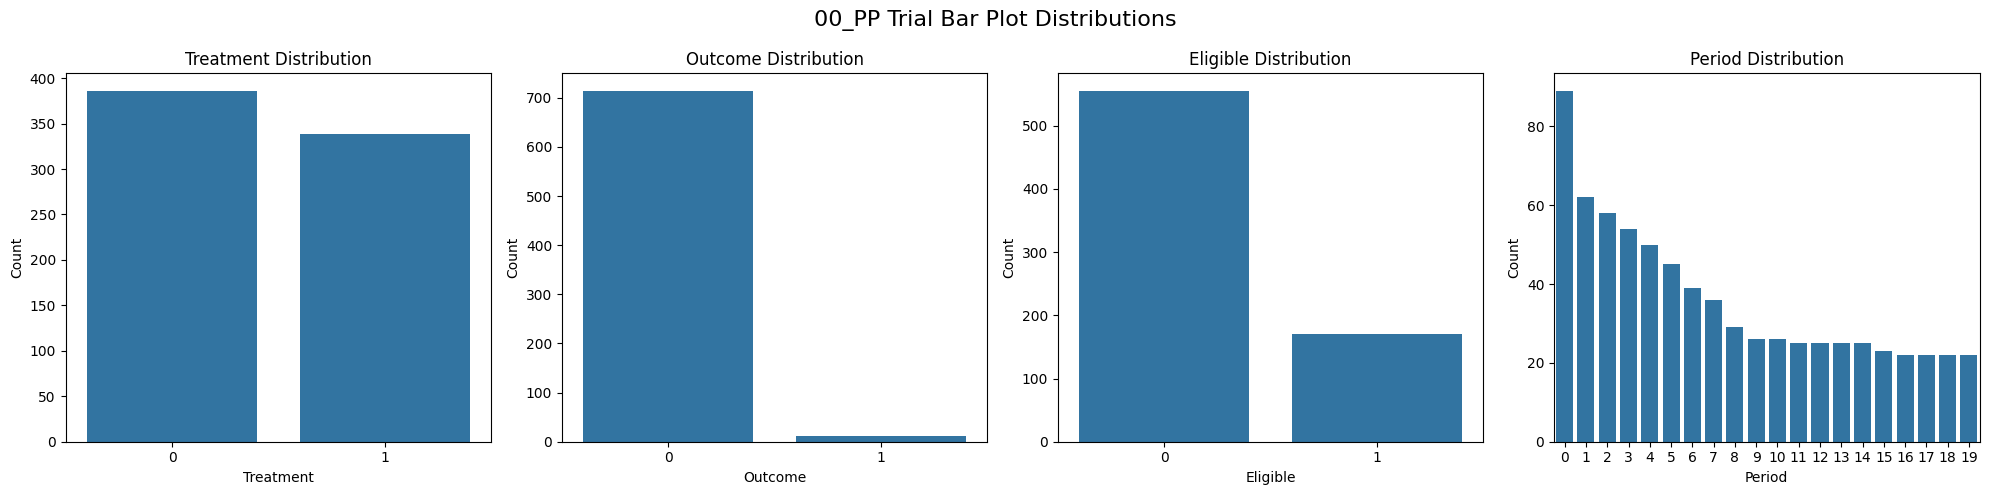

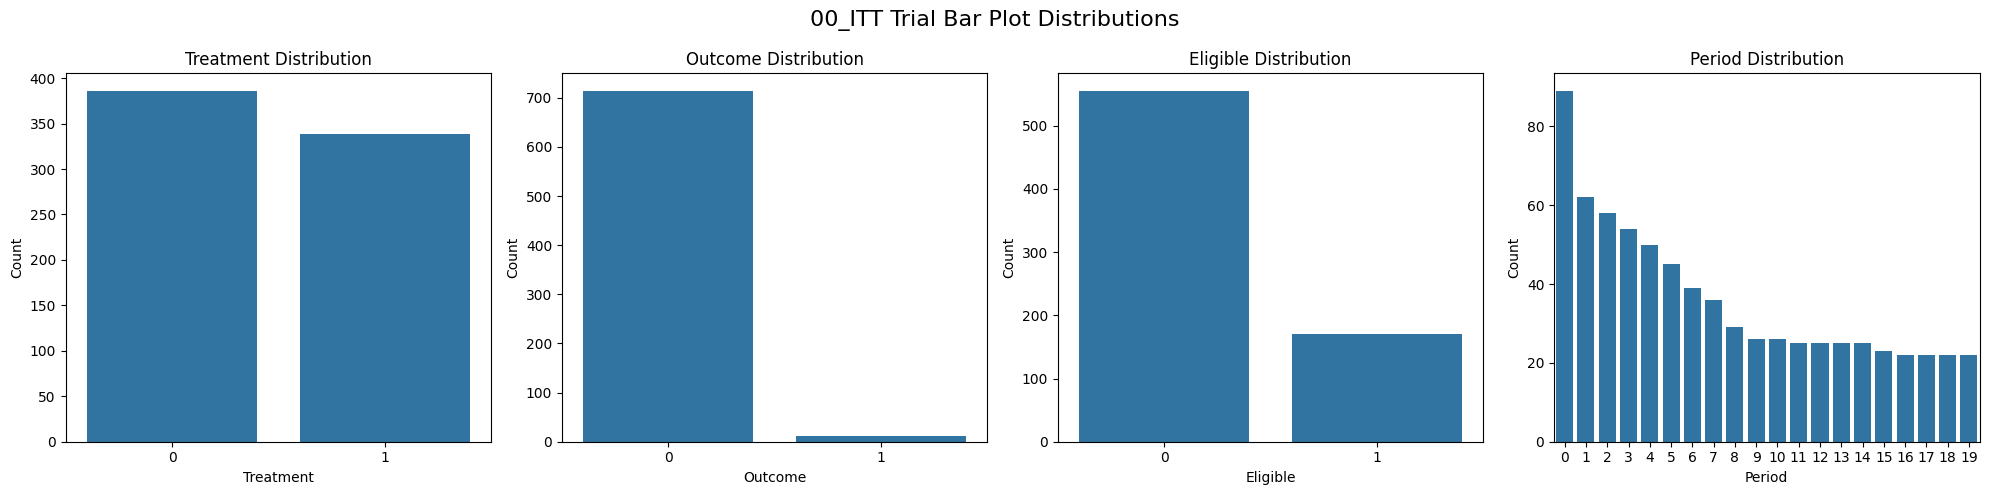

In [4]:
# Define the custom color
# custom_pink = (255/255, 0/255, 149/255)  # PINK
# custom_green = (0/255, 207/255, 121/255)  # GREEN (too bright, not good on white bg)

# Function to plot distributions
def plot_distributions(trial, title, save_dir):
    data = trial['data']
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns
    fig.suptitle(title, fontsize=16)

    # Plot treatment distribution
    sns.countplot(x=trial['treatment'], data=data, ax=axes[0])
    axes[0].set_title("Treatment Distribution")
    axes[0].set_xlabel("Treatment")
    axes[0].set_ylabel("Count")

    # Plot outcome distribution
    sns.countplot(x=trial['outcome'], data=data, ax=axes[1])
    axes[1].set_title("Outcome Distribution")
    axes[1].set_xlabel("Outcome")
    axes[1].set_ylabel("Count")

    # Plot eligible distribution
    sns.countplot(x=trial['eligible'], data=data, ax=axes[2])
    axes[2].set_title("Eligible Distribution")
    axes[2].set_xlabel("Eligible")
    axes[2].set_ylabel("Count")

    # Plot period distribution
    sns.countplot(x=trial['period'], data=data, ax=axes[3])
    axes[3].set_title("Period Distribution")
    axes[3].set_xlabel("Period")
    axes[3].set_ylabel("Count")

    plt.tight_layout()

    # Save the figure
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Create the directory if it doesn't exist
    save_path = os.path.join(save_dir, f"{title.replace(' ', '_')}.png")
    plt.savefig(save_path, bbox_inches='tight')  # Save the plot

    plt.show()

# Visualize Per-Protocol (PP) Trial
plot_distributions(trial_pp, "00_PP Trial Bar Plot Distributions", "../Datasets/trial_pp")

# Visualize Intention-to-Treat (ITT) Trial
plot_distributions(trial_itt, "00_ITT Trial Bar Plot Distributions", "../Datasets/trial_itt")

### <span style="color:rgb(255, 123, 0);">**Step 3: Weight Models and Censoring**</span>

#### <span style="color:rgb(255, 123, 0);">***Step 3.1: Treatment Switching***</span>


In [5]:
# Define file paths
data_path = "../Datasets/data_censored.csv"
trial_pp_dir = "../Datasets/trial_pp"
tte_models_dir = "../TTE Models"  # Directory for saving models

# Ensure directories exist
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(tte_models_dir, exist_ok=True)

# Load the dataset
data_censored = pd.read_csv(data_path)

# Define a function to fit logistic regression models
def fit_logit_model(data, formula, save_path=None):
    """
    Fit a logistic regression model using the specified formula.
    
    Args:
        data: DataFrame containing the data
        formula: String formula like "~ age + x1" (target is assumed to be 'treatment')
        save_path: Path to save the model (optional)
    Returns:
        Fitted LogisticRegression model
    """
    features = formula.replace("~", "").strip().split(" + ")
    X = data[features]  # Features
    y = data['treatment']  # Target (assuming 'treatment' is the column)

    model = LogisticRegression(max_iter=1000)  # Increased max_iter for convergence
    model.fit(X, y)

    if save_path:
        joblib.dump(model, save_path)

    return model

# Define the set_switch_weight_model function
def set_switch_weight_model(data, numerator, denominator, model_fitter, save_dir, tte_models_dir):
    """
    Fit numerator and denominator models for stabilized weights and calculate weights.
    
    Args:
        data: DataFrame with the dataset
        numerator: Formula for numerator model (e.g., "~ age")
        denominator: Formula for denominator model (e.g., "~ age + x1 + x3")
        model_fitter: Function to fit the models
        save_dir: Directory to save the processed data
        tte_models_dir: Directory to save the models
    Returns:
        DataFrame with added 'weights', 'num_probs', and 'denom_probs' columns
    """
    # Fit numerator model
    numerator_model = model_fitter(
        data, numerator, save_path=os.path.join(tte_models_dir, "numerator_model.pkl")
    )

    # Fit denominator model
    denominator_model = model_fitter(
        data, denominator, save_path=os.path.join(tte_models_dir, "denominator_model.pkl")
    )

    # Calculate stabilized weights and probabilities
    def calculate_stabilized_weights_and_probs(data, num_model, denom_model, num_formula, denom_formula):
        num_features = num_formula.replace("~", "").strip().split(" + ")
        denom_features = denom_formula.replace("~", "").strip().split(" + ")

        num_probs = num_model.predict_proba(data[num_features])[:, 1]
        denom_probs = denom_model.predict_proba(data[denom_features])[:, 1]
        weights = np.where(denom_probs > 0, num_probs / denom_probs, 1.0)
        return weights, num_probs, denom_probs

    # Add weights and probabilities to the dataset
    data_with_weights = data.copy()
    weights, num_probs, denom_probs = calculate_stabilized_weights_and_probs(
        data_with_weights, numerator_model, denominator_model, numerator, denominator
    )
    data_with_weights['weights'] = weights
    data_with_weights['num_probs'] = num_probs
    data_with_weights['denom_probs'] = denom_probs

    # Save the dataset with weights
    output_path = os.path.join(save_dir, "PPdata_with_weights.csv")
    data_with_weights.to_csv(output_path, index=False)
    print(f"Data with weights saved to {output_path}")

    return data_with_weights

# Define the model_fitter function (logistic regression)
def stats_glm_logit(save_path=None):
    """
    Wrapper function to fit logistic regression models.
    """
    def fit(data, formula, save_path=save_path):
        return fit_logit_model(data, formula, save_path)
    return fit

# Apply set_switch_weight_model to trial_pp only
trial_pp = set_switch_weight_model(
    data_censored,
    numerator="~ age",
    denominator="~ age + x1 + x3",
    model_fitter=stats_glm_logit(),
    save_dir=trial_pp_dir,
    tte_models_dir=tte_models_dir
)

# Do NOT apply set_switch_weight_model to trial_itt (see explanation below)
trial_itt = data_censored.copy()  # For ITT, we just use the original data for now

print("Switch weight models fitted and weights calculated for trial_pp!")

Data with weights saved to ../Datasets/trial_pp\PPdata_with_weights.csv
Switch weight models fitted and weights calculated for trial_pp!


##### <span style="color:rgb(0, 207, 121);">**Miscellanous: Data Visualization of Weights and Models**</span>

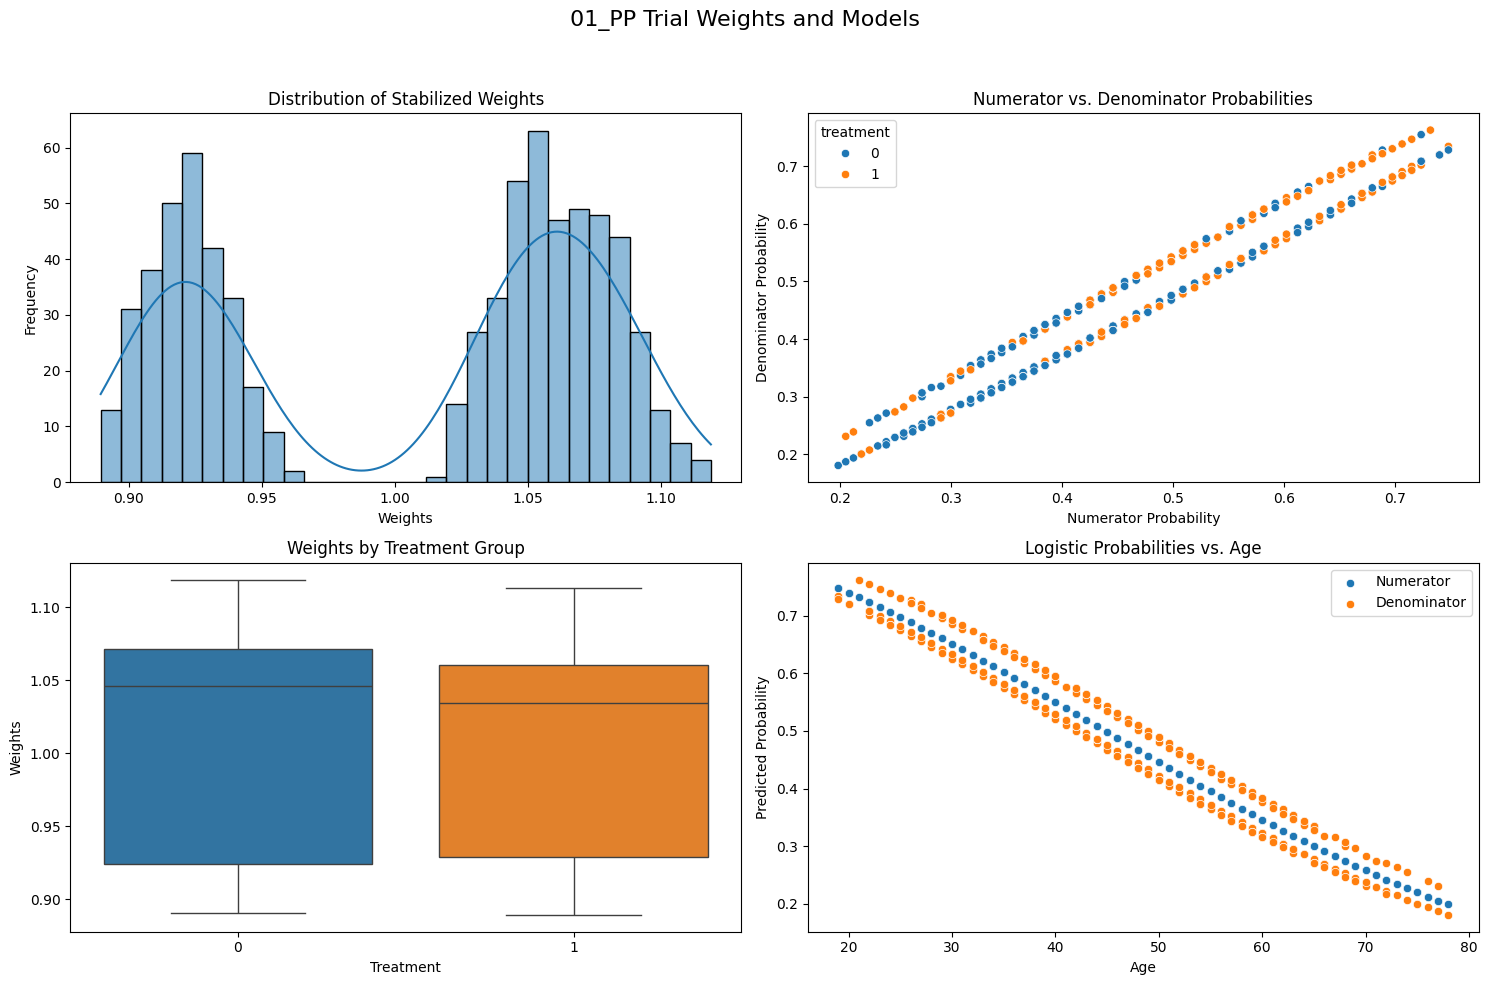

In [6]:
# Visualization function without custom colors
def visualize_weights_and_models(data, title, save_dir):
    """
    Visualize weights, numerator/denominator probabilities, and logistic fits.
    
    Args:
        data: DataFrame with 'weights', 'num_probs', 'denom_probs', 'treatment', 'age'
        title: Title for the visualization
        save_dir: Directory to save the plot
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)

    # Plot 1: Distribution of weights
    sns.histplot(data['weights'], bins=30, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title("Distribution of Stabilized Weights")
    axes[0, 0].set_xlabel("Weights")
    axes[0, 0].set_ylabel("Frequency")

    # Plot 2: Numerator vs. Denominator Probabilities
    sns.scatterplot(x=data['num_probs'], y=data['denom_probs'], hue=data['treatment'], ax=axes[0, 1])
    axes[0, 1].set_title("Numerator vs. Denominator Probabilities")
    axes[0, 1].set_xlabel("Numerator Probability")
    axes[0, 1].set_ylabel("Denominator Probability")

    # Plot 3: Weights vs. Treatment
    sns.boxplot(x=data['treatment'], y=data['weights'], hue=data['treatment'], ax=axes[1, 0], legend=False)
    axes[1, 0].set_title("Weights by Treatment Group")
    axes[1, 0].set_xlabel("Treatment")
    axes[1, 0].set_ylabel("Weights")

    # Plot 4: Logistic Fit (Probabilities vs. Age)
    sns.scatterplot(x=data['age'], y=data['num_probs'], label='Numerator', ax=axes[1, 1])
    sns.scatterplot(x=data['age'], y=data['denom_probs'], label='Denominator', ax=axes[1, 1])
    axes[1, 1].set_title("Logistic Probabilities vs. Age")
    axes[1, 1].set_xlabel("Age")
    axes[1, 1].set_ylabel("Predicted Probability")
    axes[1, 1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for suptitle
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, f"{title.replace(' ', '_')}_Visualization.png"))
    plt.show()

# Visualize results for trial_pp
visualize_weights_and_models(trial_pp, "01_PP Trial Weights and Models", trial_pp_dir)

##### <span style="color:rgb(0, 207, 121);">**Miscellanous: Visualization of Trial_PP After Treatment Switching**</span>


Plot saved to ../Datasets/trial_pp\02_PP_Trial_After_Treatment_Switching.png


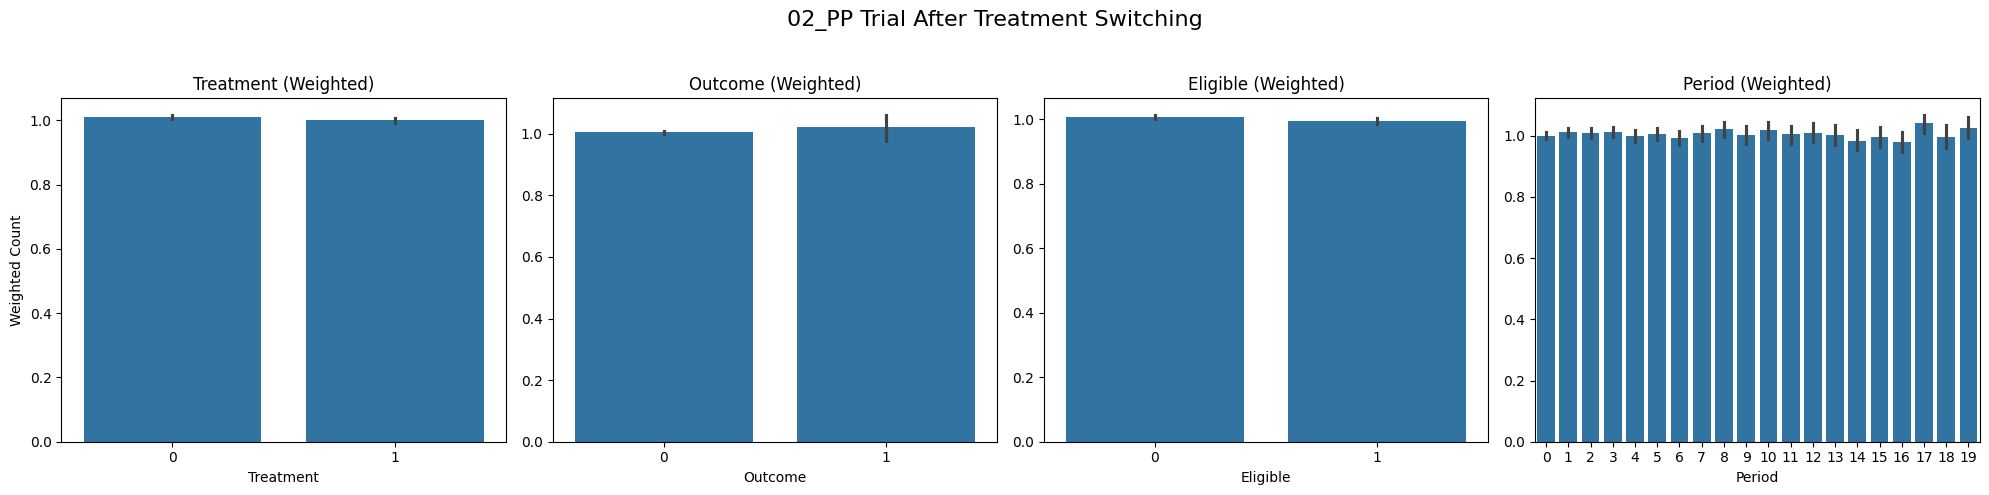

In [7]:
# File paths
data_censored_path = "../Datasets/data_censored.csv"
trial_pp_weights_path = "../Datasets/trial_pp/PPdata_with_weights.csv"
save_dir = "../Datasets/trial_pp"

# Load the datasets
data_censored = pd.read_csv(data_censored_path)
trial_pp = pd.read_csv(trial_pp_weights_path)

# Function to plot unweighted (before) vs weighted (after) distributions
def plot_before_after_distributions(after_data, title, save_dir):
    """
    Plot bar graphs comparing distributions before and after treatment switching.
    
    Args:
        before_data: DataFrame with original unweighted data (data_censored)
        after_data: DataFrame with weighted data (PPdata_with_weights)
        title: Title for the plot
        save_dir: Directory to save the plot
    """
    # Ensure save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Set up the figure with 1 row and 4 columns (variables)
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(title, fontsize=16)

    # Variables to plot
    variables = ['treatment', 'outcome', 'eligible', 'period']

    for i, var in enumerate(variables):
        # # Before (Unweighted) distribution - raw counts
        # sns.countplot(x=var, data=before_data, ax=axes[0, i])
        # axes[0, i].set_title(f"{var.capitalize()} (Unweighted)")
        # axes[0, i].set_xlabel(var.capitalize())
        # if i == 0:
        #     axes[0, i].set_ylabel("Count")
        # else:
        #     axes[0, i].set_ylabel("")

        # After (Weighted) distribution - using weights
        weighted_counts = after_data.groupby(var)['weights'].sum().reset_index()
        # print(f"{var}: {weighted_counts}")
        sns.barplot(x=var, y='weights', data=after_data, ax=axes[i])  
        axes[i].set_title(f"{var.capitalize()} (Weighted)")
        axes[i].set_xlabel(var.capitalize())
        if i == 0:
            axes[i].set_ylabel("Weighted Count")
        else:
            axes[i].set_ylabel("")

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle

    # Save the plot
    save_path = os.path.join(save_dir, f"{title.replace(' ', '_')}.png")
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Plot saved to {save_path}")

    # Display the plot
    plt.show()

# Plot distributions comparing before (data_censored) and after (trial_pp)
plot_before_after_distributions(
    trial_pp,
    "02_PP Trial After Treatment Switching",
    save_dir
)

#### <span style="color:rgb(255, 123, 0);">***Step 3.2: Informative Censoring***</span>

In [8]:
# File paths
trial_pp_dir = "../Datasets/trial_pp"
trial_itt_dir = "../Datasets/trial_itt"
save_dir_pp = os.path.join(trial_pp_dir, "switch_models")
save_dir_itt = os.path.join(trial_itt_dir, "switch_models")

# Ensure directories exist
os.makedirs(save_dir_pp, exist_ok=True)
os.makedirs(save_dir_itt, exist_ok=True)

# Load datasets
trial_pp = pd.read_csv("../Datasets/trial_pp/PPdata_with_weights.csv")
trial_itt = pd.read_csv("../Datasets/data_censored.csv")

# Define the logistic regression fitter function (using statsmodels)
def stats_glm_logit(save_path=None):
    def fit(data, formula, save_path=save_path):
        # Ensure formula includes the dependent variable
        if 'censored' in data.columns:
            formula = f"1 - censored ~ {formula}"
        print(f"Debug: Fitting model with formula: {formula}")
        print(f"Debug: Data columns: {data.columns.tolist()}")
        model = smf.logit(formula=formula, data=data).fit(disp=0)
        if save_path:
            joblib.dump(model, save_path)
        return model
    return fit

# Function to set censor weight model
def set_censor_weight_model(data, censor_event, numerator, denominator, pool_models, save_dir):
    data.attrs['censor_weights'] = {
        'censor_event': censor_event,  # Fixed: Added censor_event to the dictionary
        'numerator_formula': numerator,
        'denominator_formula': denominator,
        'model_fitter_type': 'te_stats_glm_logit',
        'fitted': False,
        'pool_models': pool_models
    }
    data['censor_weights'] = None
    return data

# Function to set treatment weight model
def set_treatment_weight_model(data, numerator, denominator, pool_models, save_dir):
    data.attrs['treatment_weights'] = {
        'numerator_formula': numerator,
        'denominator_formula': denominator,
        'model_fitter_type': 'te_stats_glm_logit',
        'fitted': False,
        'pool_models': pool_models
    }
    data['treatment_weights'] = None
    return data

# Apply censor weight model setup
trial_pp = set_censor_weight_model(trial_pp, censor_event="censored", numerator="~ x2", denominator="~ x2 + x1", pool_models="none", save_dir=save_dir_pp)
trial_itt = set_censor_weight_model(trial_itt, censor_event="censored", numerator="~ x2", denominator="~ x2 + x1", pool_models="numerator", save_dir=save_dir_itt)

# Apply treatment weight model setup (for trial_pp)
trial_pp = set_treatment_weight_model(trial_pp, numerator="~ age", denominator="~ age + x1 + x3", pool_models="none", save_dir=save_dir_pp)

# Print censor weights setup
print("trial_pp@censor_weights:")
for key, value in trial_pp.attrs['censor_weights'].items():
    print(f" - {key.replace('_', ' ').title()}: {value}")
if not trial_pp.attrs['censor_weights']['fitted']:
    print(" - Weight models not fitted. Use calculate_weights()")

print("trial_itt@censor_weights:")
for key, value in trial_itt.attrs['censor_weights'].items():
    print(f" - {key.replace('_', ' ').title()}: {value}")
if not trial_itt.attrs['censor_weights']['fitted']:
    print(" - Weight models not fitted. Use calculate_weights()")

trial_pp@censor_weights:
 - Censor Event: censored
 - Numerator Formula: ~ x2
 - Denominator Formula: ~ x2 + x1
 - Model Fitter Type: te_stats_glm_logit
 - Fitted: False
 - Pool Models: none
 - Weight models not fitted. Use calculate_weights()
trial_itt@censor_weights:
 - Censor Event: censored
 - Numerator Formula: ~ x2
 - Denominator Formula: ~ x2 + x1
 - Model Fitter Type: te_stats_glm_logit
 - Fitted: False
 - Pool Models: numerator
 - Weight models not fitted. Use calculate_weights()


##### <span style="color:rgb(0, 207, 121);">**Miscellanous: Visualization of Unweighted Distributions for Trial_PP and Trial_ITT**</span>

Plot saved to ../Datasets/trial_pp\10_Trial_PP_Unweighted_Distributions.png


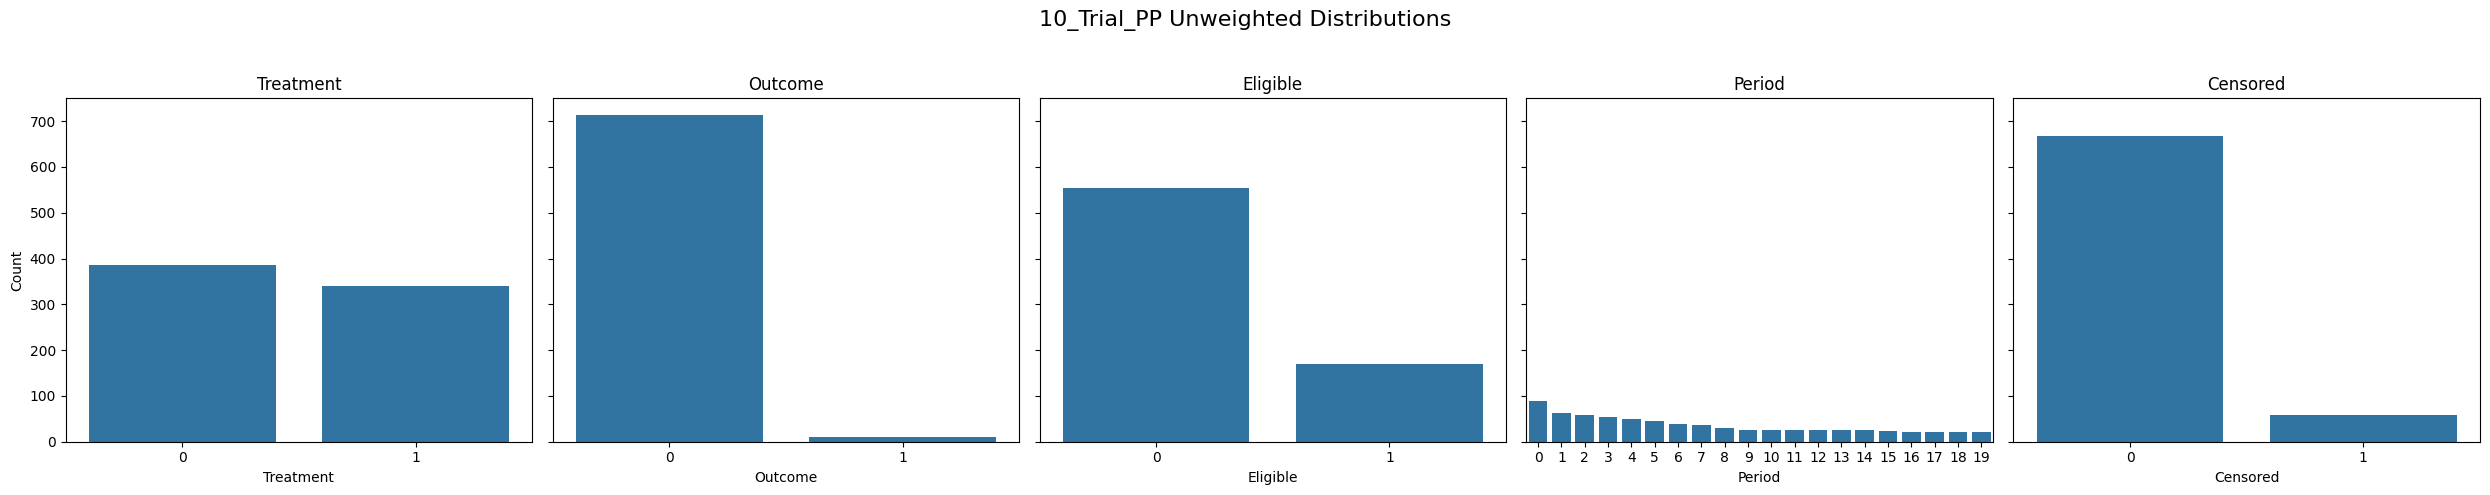

Plot saved to ../Datasets/trial_itt\10_Trial_ITT_Unweighted_Distributions.png


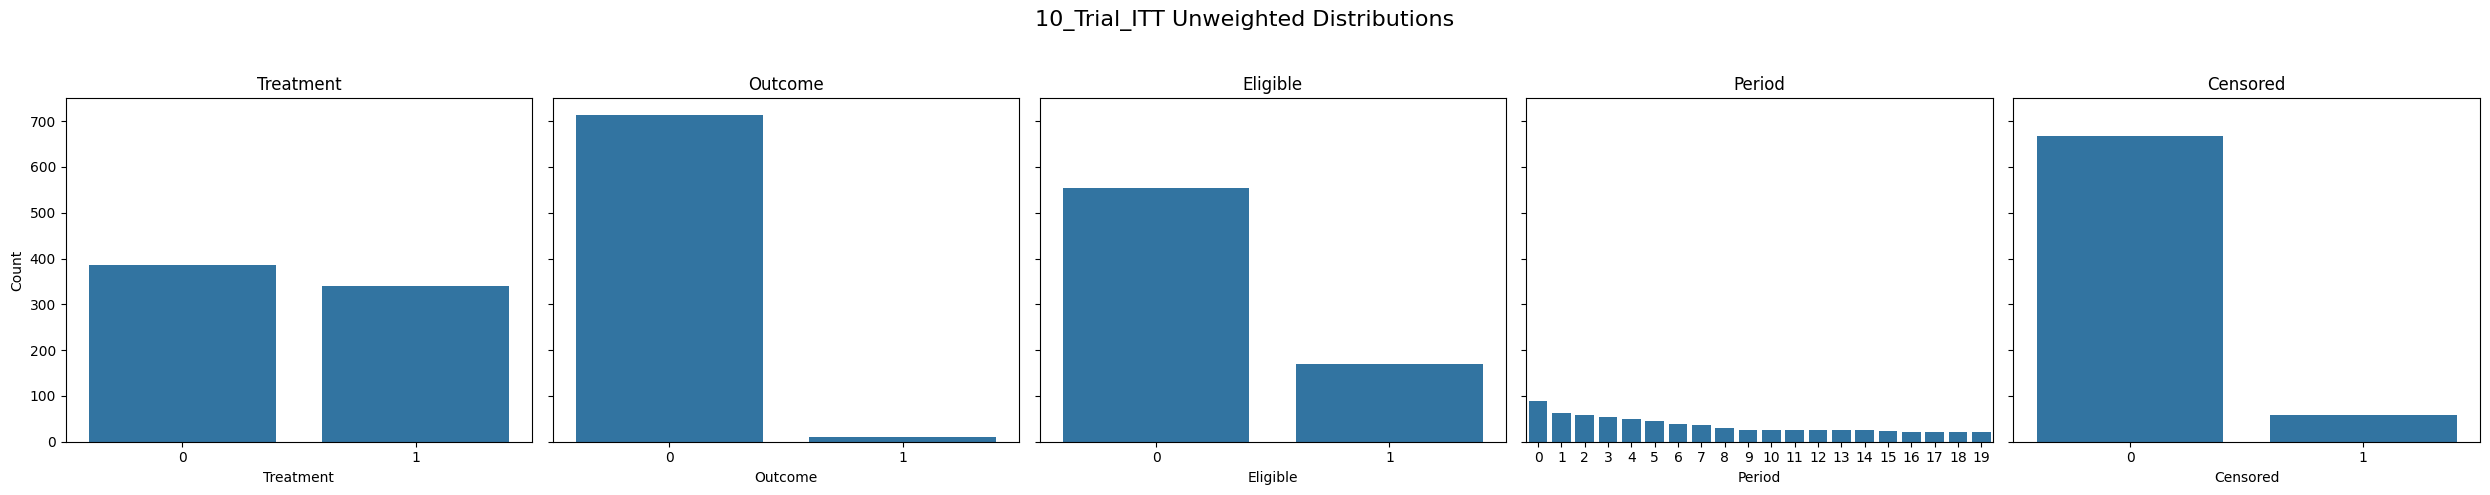

In [9]:
### Function to plot unweighted distributions
def plot_unweighted_distributions(data, title, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    variables = ['treatment', 'outcome', 'eligible', 'period', 'censored']
    missing_vars = [var for var in variables if var not in data.columns]
    if missing_vars:
        raise ValueError(f"Dataset is missing columns: {missing_vars}")

    data_clean = data[variables].dropna()

    fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
    fig.suptitle(title, fontsize=16)

    for i, var in enumerate(variables):
        sns.countplot(x=var, data=data_clean, ax=axes[i])
        axes[i].set_title(f"{var.capitalize()}")
        axes[i].set_xlabel(var.capitalize())
        if i == 0:
            axes[i].set_ylabel("Count")
        else:
            axes[i].set_ylabel("")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    save_path = os.path.join(save_dir, f"{title.replace(' ', '_')}.png")
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Plot saved to {save_path}")
    plt.show()

# Visualize unweighted distributions (before weights)
plot_unweighted_distributions(trial_pp, "10_Trial_PP Unweighted Distributions", trial_pp_dir)
plot_unweighted_distributions(trial_itt, "10_Trial_ITT Unweighted Distributions", trial_itt_dir)

### <span style="color:rgb(255, 123, 0);">**Step 4: Use Calculated Weights**</span>

In [10]:
def calculate_weights(data, save_dir=None):
    """
    Calculate weights for censoring and/or treatment switching based on data.attrs configuration.
    Updates the dataset with weights and returns it.
    
    Args:
        data: DataFrame with attrs['censor_weights'] and/or attrs['treatment_weights']
        save_dir: Directory to save models (overrides default if provided)
    Returns:
        DataFrame with weights added
    """
    if save_dir is None:
        save_dir = Path('trial_data/switch_models')
    save_dir.mkdir(parents=True, exist_ok=True)

    fitted_models = {}

    # Handle censoring weights
    if 'censor_weights' in data.attrs:
        censor_config = data.attrs['censor_weights']
        censor_col = censor_config['censor_event']
        numerator_formula = censor_config['numerator_formula'].replace("~", "").strip()
        denominator_formula = censor_config['denominator_formula'].replace("~", "").strip()
        pool_models = censor_config['pool_models']
        model_fitter = stats_glm_logit()

        # Check variability
        print(f"Checking variability for {censor_col}: {data[censor_col].value_counts()}")
        num_features = numerator_formula.split(" + ")
        for feature in num_features:
            print(f"Checking variability for {feature}: {data[feature].nunique()} unique values")

        if data[censor_col].nunique() < 2:
            print(f"Warning: '{censor_col}' has no variability. Setting censor_weights to 1.")
            data['censor_weights'] = 1.0
        elif any(data[feature].nunique() < 2 for feature in num_features):
            print(f"Warning: One or more predictors in '{numerator_formula}' have no variability. Setting censor_weights to 1.")
            data['censor_weights'] = 1.0
        else:
            try:
                # Fit numerator model with regularization if needed
                num_model = model_fitter(
                    data, numerator_formula, save_path=save_dir / "censor_numerator_model.pkl"
                )
                num_probs = num_model.predict(data[num_features])
                # Clip probabilities to avoid numerical issues
                num_probs = np.clip(num_probs, 1e-10, 1 - 1e-10)

                denom_probs = np.ones(len(data))
                if pool_models == "none":
                    denom_model = model_fitter(
                        data, denominator_formula, save_path=save_dir / "censor_denominator_model.pkl"
                    )
                    denom_features = denominator_formula.split(" + ")
                    denom_probs = denom_model.predict(data[denom_features])
                    denom_probs = np.clip(denom_probs, 1e-10, 1 - 1e-10)
                    fitted_models['censor_d'] = denom_model
                elif pool_models == "numerator":
                    denom_probs = num_probs
                else:
                    for prev_trt in [0, 1]:
                        subset = data[data['previous_treatment'] == prev_trt]
                        if len(subset) > 0 and subset[censor_col].nunique() >= 2:
                            denom_model = model_fitter(
                                subset, denominator_formula, 
                                save_path=save_dir / f"censor_denominator_model_prev{prev_trt}.pkl"
                            )
                            denom_features = denominator_formula.split(" + ")
                            denom_probs_subset = denom_model.predict(subset[denom_features])
                            denom_probs_subset = np.clip(denom_probs_subset, 1e-10, 1 - 1e-10)
                            data.loc[data['previous_treatment'] == prev_trt, 'denom_probs_censor'] = denom_probs_subset
                            fitted_models[f'censor_d{prev_trt}'] = denom_model
                    denom_probs = data['denom_probs_censor'].fillna(1.0)

                censor_weights = np.where(denom_probs > 0, num_probs / denom_probs, 1.0)
                data['censor_weights'] = censor_weights
                fitted_models['censor_n'] = num_model
                censor_config['fitted'] = True

            except (np.linalg.LinAlgError, PerfectSeparationError) as e:
                print(f"Warning: Failed to fit censoring model due to {str(e)}. Trying sklearn with regularization.")
                # Fallback to sklearn with regularization
                num_model = LogisticRegression(max_iter=1000, penalty='l2', C=1.0)
                num_model.fit(data[num_features], 1 - data[censor_col])
                num_probs = num_model.predict_proba(data[num_features])[:, 1]
                num_probs = np.clip(num_probs, 1e-10, 1 - 1e-10)

                if pool_models == "none":
                    denom_model = LogisticRegression(max_iter=1000, penalty='l2', C=1.0)
                    denom_features = denominator_formula.split(" + ")
                    denom_model.fit(data[denom_features], 1 - data[censor_col])
                    denom_probs = denom_model.predict_proba(data[denom_features])[:, 1]
                    denom_probs = np.clip(denom_probs, 1e-10, 1 - 1e-10)
                    fitted_models['censor_d'] = denom_model
                elif pool_models == "numerator":
                    denom_probs = num_probs

                censor_weights = np.where(denom_probs > 0, num_probs / denom_probs, 1.0)
                data['censor_weights'] = censor_weights
                fitted_models['censor_n'] = num_model
                censor_config['fitted'] = True

    # Handle treatment switching weights
    if 'treatment_weights' in data.attrs:
        trt_config = data.attrs['treatment_weights']
        numerator_formula = trt_config['numerator_formula'].replace("~", "").strip()
        denominator_formula = trt_config['denominator_formula'].replace("~", "").strip()

        try:
            num_path = Path("../TTE Models/numerator_model.pkl")
            if num_path.exists():
                num_model = joblib.load(num_path)
                num_features = numerator_formula.split(" + ")
                num_probs = num_model.predict_proba(data[num_features])[:, 1]
            else:
                num_model = LogisticRegression(max_iter=1000, penalty='l2', C=1.0)
                num_model.fit(data[num_features], data['treatment'])
                num_probs = num_model.predict_proba(data[num_features])[:, 1]
                joblib.dump(num_model, save_dir / "treatment_numerator_model.pkl")

            denom_path = Path("../TTE Models/denominator_model.pkl")
            if denom_path.exists():
                denom_model = joblib.load(denom_path)
                denom_features = denominator_formula.split(" + ")
                denom_probs = denom_model.predict_proba(data[denom_features])[:, 1]
            else:
                denom_model = LogisticRegression(max_iter=1000, penalty='l2', C=1.0)
                denom_model.fit(data[denom_features], data['treatment'])
                denom_probs = denom_model.predict_proba(data[denom_features])[:, 1]
                joblib.dump(denom_model, save_dir / "treatment_denominator_model.pkl")

            trt_weights = np.where(denom_probs > 0, num_probs / denom_probs, 1.0)
            data['treatment_weights'] = trt_weights
            fitted_models['treatment_n'] = num_model
            fitted_models['treatment_d'] = denom_model
            trt_config['fitted'] = True

        except Exception as e:
            print(f"Warning: Failed to fit treatment model due to {str(e)}. Setting treatment_weights to 1.")
            data['treatment_weights'] = 1.0

    data.attrs['fitted_models'] = fitted_models
    return data

# Update show_weight_models to handle sklearn models consistently
def show_weight_models(data):
    if 'fitted_models' not in data.attrs or not data.attrs['fitted_models']:
        print("No fitted weight models available. Run calculate_weights() first.")
        return

    models = data.attrs['fitted_models']

    if 'censor_weights' in data.attrs:
        print("Weight Models for Informative Censoring")
        print("---------------------------------------")
        if 'censor_n' in models:
            print("\n[[Numerator]]")
            print(f"Model: P({data.attrs['censor_weights']['censor_event']} = 0 | {data.attrs['censor_weights']['numerator_formula']})")
            if hasattr(models['censor_n'], 'summary'):
                print(models['censor_n'].summary())
            else:
                print(f"Coefficients: {models['censor_n'].coef_}")
                print(f"Intercept: {models['censor_n'].intercept_}")
        if 'censor_d' in models:
            print("\n[[Denominator]]")
            print(f"Model: P({data.attrs['censor_weights']['censor_event']} = 0 | {data.attrs['censor_weights']['denominator_formula']})")
            if hasattr(models['censor_d'], 'summary'):
                print(models['censor_d'].summary())
            else:
                print(f"Coefficients: {models['censor_d'].coef_}")
                print(f"Intercept: {models['censor_d'].intercept_}")

    if 'treatment_weights' in data.attrs:
        print("\nWeight Models for Treatment Switching")
        print("-------------------------------------")
        if 'treatment_n' in models:
            print("\n[[Numerator]]")
            print(f"Model: P(treatment = 1 | {data.attrs['treatment_weights']['numerator_formula']})")
            if hasattr(models['treatment_n'], 'summary'):
                print(models['treatment_n'].summary())
            else:
                print(f"Coefficients: {models['treatment_n'].coef_}")
                print(f"Intercept: {models['treatment_n'].intercept_}")
        if 'treatment_d' in models:
            print("\n[[Denominator]]")
            print(f"Model: P(treatment = 1 | {data.attrs['treatment_weights']['denominator_formula']})")
            if hasattr(models['treatment_d'], 'summary'):
                print(models['treatment_d'].summary())
            else:
                print(f"Coefficients: {models['treatment_d'].coef_}")
                print(f"Intercept: {models['treatment_d'].intercept_}")

# Run the updated code
save_dir_pp = Path("../Datasets/trial_pp/switch_models")
save_dir_itt = Path("../Datasets/trial_itt/switch_models")

trial_pp = calculate_weights(trial_pp, save_dir=save_dir_pp)
trial_itt = calculate_weights(trial_itt, save_dir=save_dir_itt)

print("\nPer-Protocol (PP) Trial Weight Models:")
show_weight_models(trial_pp)

print("\nIntention-to-Treat (ITT) Trial Weight Models:")
show_weight_models(trial_itt)

Checking variability for censored: censored
0    667
1     58
Name: count, dtype: int64
Checking variability for x2: 725 unique values
Debug: Fitting model with formula: 1 - censored ~ x2
Debug: Data columns: ['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'censored', 'eligible', 'weights', 'num_probs', 'denom_probs', 'censor_weights', 'treatment_weights']
Checking variability for censored: censored
0    667
1     58
Name: count, dtype: int64
Checking variability for x2: 725 unique values
Debug: Fitting model with formula: 1 - censored ~ x2
Debug: Data columns: ['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'censored', 'eligible', 'censor_weights']

Per-Protocol (PP) Trial Weight Models:
Weight Models for Informative Censoring
---------------------------------------

[[Numerator]]
Model: P(censored = 0 | ~ x2)
Coefficients: [[-0.44005483]]
Intercept: [2.44601542]

[[Denominator]]
Model: P(censored = 0 | ~ x2 + x1)
Coeff

c:\Users\Fabiola\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\Fabiola\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\Fabiola\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\Fabiola\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or predi

##### <span style="color:rgb(0, 207, 121);">**Miscellanous: Visualization of Weighted Distributions for Trial_PP and Trial_ITT**</span>

C:\Users\Fabiola\AppData\Local\Temp\ipykernel_13204\2600550868.py:49: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=trial_itt, x=weight_col, label=f'{weight_col} KDE', fill=True, alpha=0.5, ax=ax)


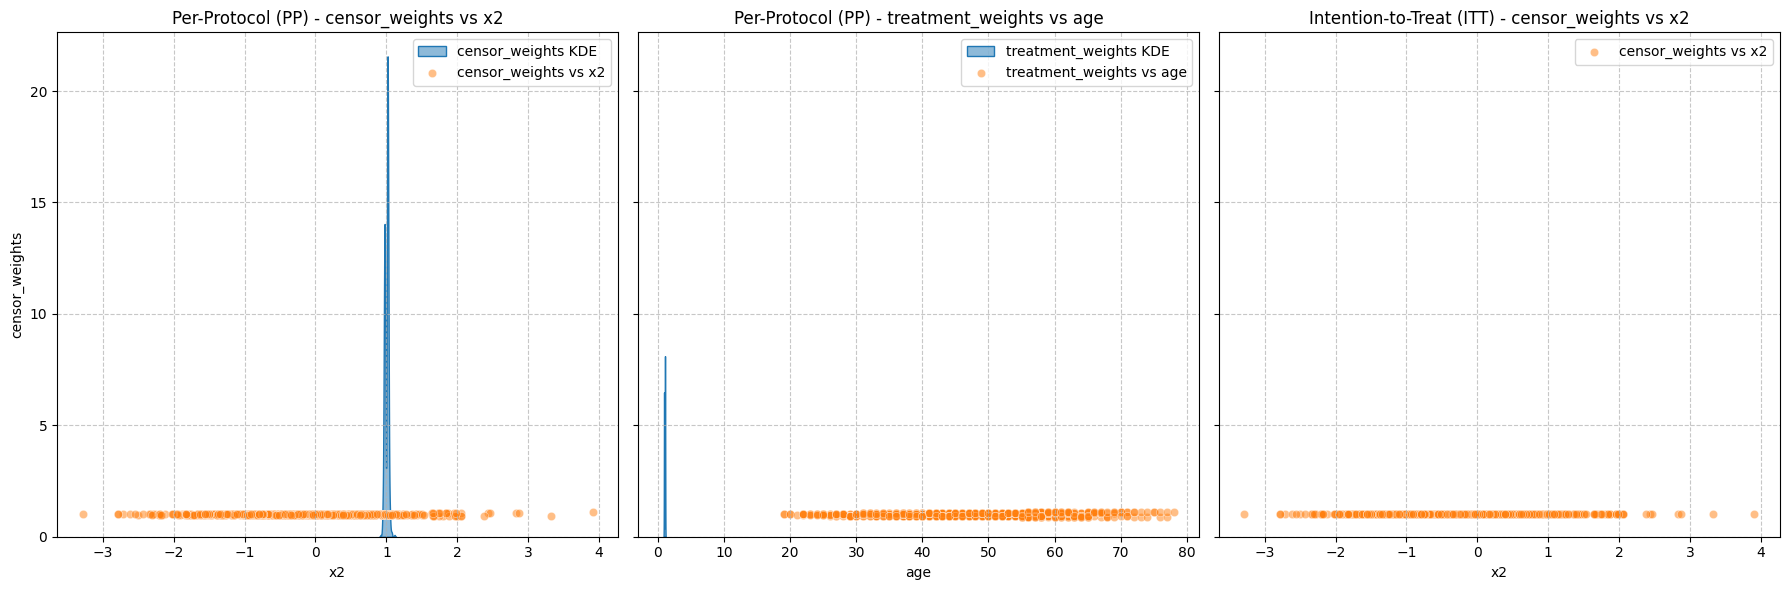

In [11]:
def plot_weights_subplots(trial_pp, trial_itt, weight_cols=['censor_weights'], x_vars=['x2'], layout='horizontal'):
    """
    Generate subplots with KDE and scatter overlay for weights in trial_pp and trial_itt datasets.
    
    Args:
        trial_pp: DataFrame for Per-Protocol dataset
        trial_itt: DataFrame for Intention-to-Treat dataset
        weight_cols: List of weight columns to plot (e.g., ['censor_weights', 'treatment_weights'])
        x_vars: List of variables to plot against weights on the x-axis (e.g., ['x2', 'age'])
        layout: 'horizontal' for side-by-side, 'vertical' for stacked subplots
    """
    # Determine number of subplots based on available weight columns
    pp_plots = sum(1 for col in weight_cols if col in trial_pp.columns)
    itt_plots = sum(1 for col in weight_cols if col in trial_itt.columns)
    total_plots = pp_plots + itt_plots

    if total_plots == 0:
        print("No weight columns available to plot.")
        return

    # Set figure size and layout
    if layout == 'horizontal':
        fig, axes = plt.subplots(1, total_plots, figsize=(6 * total_plots, 6), sharey=True)
        axes = axes.flatten() if total_plots > 1 else [axes]
    else:  # vertical
        fig, axes = plt.subplots(total_plots, 1, figsize=(10, 4 * total_plots), sharex=False)
        axes = axes.flatten() if total_plots > 1 else [axes]

    # Plot index
    plot_idx = 0

    # Plot for trial_pp
    for weight_col, x_var in zip(weight_cols, x_vars + [x_vars[-1]] * (len(weight_cols) - len(x_vars))):
        if weight_col in trial_pp.columns:
            ax = axes[plot_idx]
            sns.kdeplot(data=trial_pp, x=weight_col, label=f'{weight_col} KDE', fill=True, alpha=0.5, ax=ax)
            sns.scatterplot(data=trial_pp, x=x_var, y=weight_col, alpha=0.5, label=f'{weight_col} vs {x_var}', ax=ax)
            ax.set_title(f'Per-Protocol (PP) - {weight_col} vs {x_var}')
            ax.set_xlabel(x_var)
            ax.set_ylabel(weight_col)
            ax.legend()
            ax.grid(True, linestyle='--', alpha=0.7)
            plot_idx += 1

    # Plot for trial_itt
    for weight_col, x_var in zip(weight_cols, x_vars + [x_vars[-1]] * (len(weight_cols) - len(x_vars))):
        if weight_col in trial_itt.columns:
            ax = axes[plot_idx]
            sns.kdeplot(data=trial_itt, x=weight_col, label=f'{weight_col} KDE', fill=True, alpha=0.5, ax=ax)
            sns.scatterplot(data=trial_itt, x=x_var, y=weight_col, alpha=0.5, label=f'{weight_col} vs {x_var}', ax=ax)
            ax.set_title(f'Intention-to-Treat (ITT) - {weight_col} vs {x_var}')
            ax.set_xlabel(x_var)
            ax.set_ylabel(weight_col)
            ax.legend()
            ax.grid(True, linestyle='--', alpha=0.7)
            plot_idx += 1

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Example usage after running your calculate_weights() code
plot_weights_subplots(
    trial_pp, 
    trial_itt, 
    weight_cols=['censor_weights', 'treatment_weights'], 
    x_vars=['x2', 'age'], 
    layout='horizontal'  # Change to 'vertical' for stacked plots
)

### <span style="color:rgb(255, 123, 0);">**Step 5: Specify Outcome Model**</span>

In [12]:
def set_outcome_model(data, adjustment_terms=None):
    """
    Specify the outcome model for the dataset, including stabilized weight numerators and optional adjustment terms.
    
    Args:
        data: DataFrame containing trial data with attrs['censor_weights'] and/or attrs['treatment_weights']
        adjustment_terms: Optional string or list of additional adjustment terms (e.g., 'x2' or ['x2', 'age'])
    
    Returns:
        DataFrame with updated attrs['outcome_model']
    """
    # Initialize outcome model dictionary in attrs
    if 'outcome_model' not in data.attrs:
        data.attrs['outcome_model'] = {}

    # Automatically include numerator terms from stabilized weight models
    numerator_terms = []
    if 'censor_weights' in data.attrs:
        numerator_terms.append(data.attrs['censor_weights']['numerator_formula'].replace("~", "").strip())
    if 'treatment_weights' in data.attrs:
        numerator_terms.append(data.attrs['treatment_weights']['numerator_formula'].replace("~", "").strip())

    # Add adjustment terms if provided
    if adjustment_terms is not None:
        if isinstance(adjustment_terms, str):
            adjustment_terms = adjustment_terms.replace("~", "").strip().split(" + ")
        elif not isinstance(adjustment_terms, list):
            raise ValueError("adjustment_terms must be a string or list")
        all_terms = numerator_terms + adjustment_terms
    else:
        all_terms = numerator_terms

    # Store the full formula in attrs
    data.attrs['outcome_model']['formula'] = "outcome ~ " + " + ".join(all_terms) if all_terms else "outcome ~ 1"
    data.attrs['outcome_model']['fitted'] = False

    return data

# Example usage
# Assuming trial_pp and trial_itt have been set up with censor_weights and treatment_weights
trial_pp = set_outcome_model(trial_pp)  # Default model with only weight numerators
trial_itt = set_outcome_model(trial_itt, adjustment_terms="~x2")  # Model with x2 adjustment

# Print the resulting formulas to verify
print("trial_pp outcome model formula:", trial_pp.attrs['outcome_model']['formula'])
print("trial_itt outcome model formula:", trial_itt.attrs['outcome_model']['formula'])

trial_pp outcome model formula: outcome ~ x2 + age
trial_itt outcome model formula: outcome ~ x2 + x2


##### <span style="color:rgb(0, 207, 121);">**Model Summaries**</span>

In [13]:
# Fit the outcome model for trial_pp
formula_pp = trial_pp.attrs['outcome_model']['formula']
model_pp = smf.ols(formula_pp, data=trial_pp).fit()

# Fit the outcome model for trial_itt
formula_itt = trial_itt.attrs['outcome_model']['formula']
model_itt = smf.ols(formula_itt, data=trial_itt).fit()

# Print model summaries
print("trial_pp model summary:")
print(model_pp.summary())

print("trial_itt model summary:")
print(model_itt.summary())


trial_pp model summary:
                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5755
Date:                Sun, 09 Mar 2025   Prob (F-statistic):              0.563
Time:                        13:59:27   Log-Likelihood:                 495.64
No. Observations:                 725   AIC:                            -985.3
Df Residuals:                     722   BIC:                            -971.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.999e-05      0

##### <span style="color:rgb(0, 207, 121);">**Miscellanous: Visualization of the Outcome Model**</span>

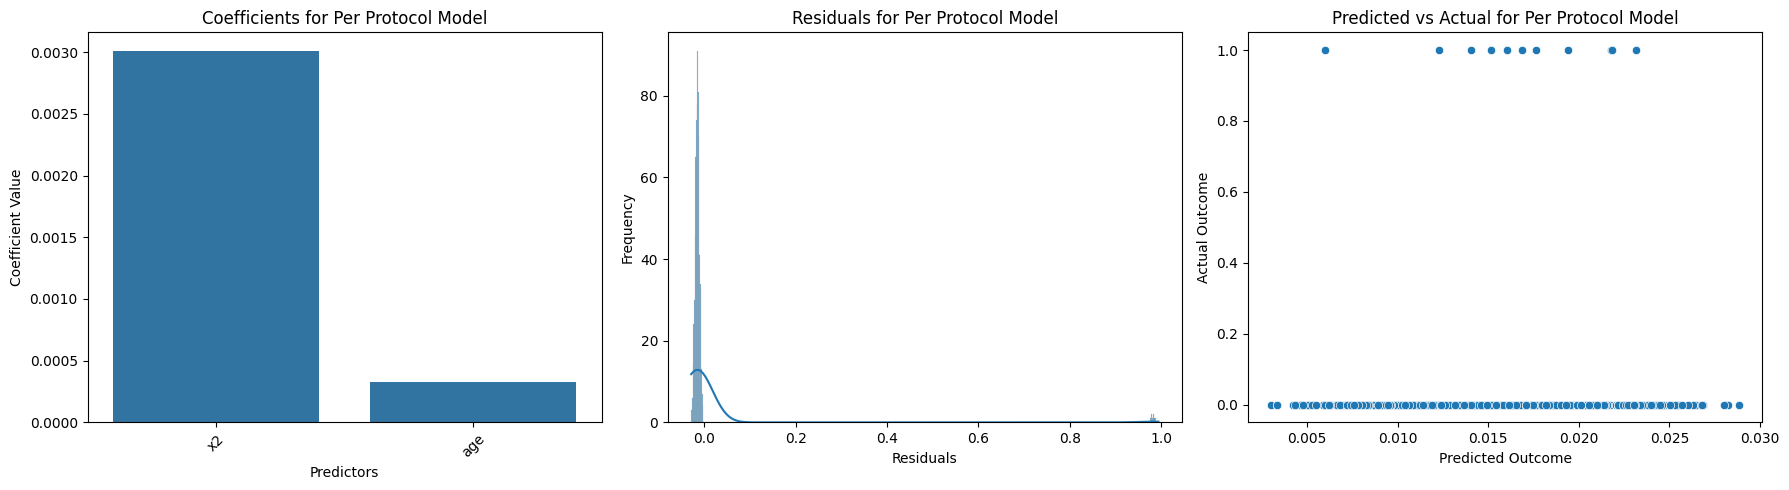

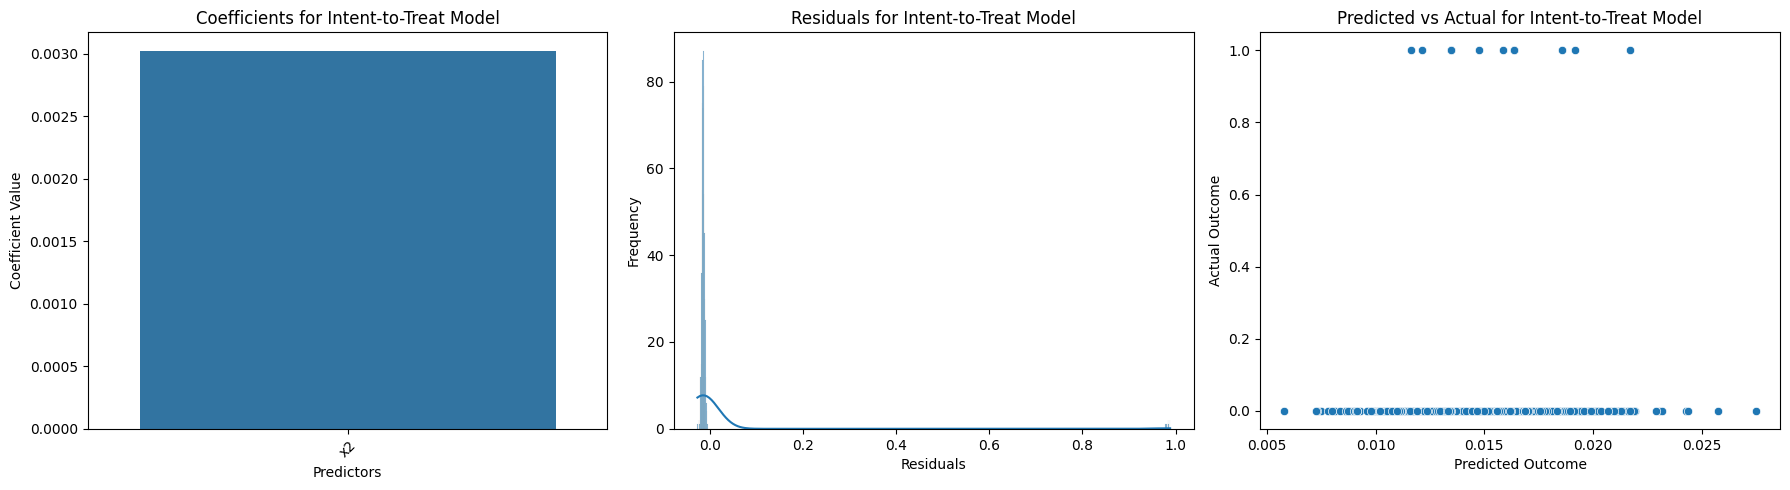

In [14]:
os.makedirs("../Datasets/trial_pp", exist_ok=True)
os.makedirs("../Datasets/trial_itt", exist_ok=True)

# Function to plot coefficients
def plot_coefficients(ax, model, title):
    coefs = model.params.drop('Intercept')  # Drop intercept for better visualization
    sns.barplot(x=coefs.index, y=coefs.values, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predictors')
    ax.set_ylabel('Coefficient Value')
    ax.tick_params(axis='x', rotation=45)

# Function to plot residuals
def plot_residuals(ax, model, title):
    residuals = model.resid
    sns.histplot(residuals, kde=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')

# Function to plot predicted vs actual
def plot_predicted_vs_actual(ax, model, data, title):
    predicted = model.predict(data)
    sns.scatterplot(x=predicted, y=data['outcome'], ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Outcome')
    ax.set_ylabel('Actual Outcome')

# Create subplots for trial_pp
fig_pp, axes_pp = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns for horizontal layout

# Plot coefficients, residuals, and predicted vs actual for trial_pp
plot_coefficients(axes_pp[0], model_pp, 'Coefficients for Per Protocol Model')
plot_residuals(axes_pp[1], model_pp, 'Residuals for Per Protocol Model')
plot_predicted_vs_actual(axes_pp[2], model_pp, trial_pp, 'Predicted vs Actual for Per Protocol Model')

# Adjust layout and save trial_pp figure
plt.tight_layout()
plt.savefig("../Datasets/trial_pp/20_Trial_PP_plots.png", dpi=300, bbox_inches='tight')

# Create subplots for trial_itt
fig_itt, axes_itt = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns for horizontal layout

# Plot coefficients, residuals, and predicted vs actual for trial_itt
plot_coefficients(axes_itt[0], model_itt, 'Coefficients for Intent-to-Treat Model')
plot_residuals(axes_itt[1], model_itt, 'Residuals for Intent-to-Treat Model')
plot_predicted_vs_actual(axes_itt[2], model_itt, trial_itt, 'Predicted vs Actual for Intent-to-Treat Model')

# Adjust layout and save trial_itt figure
plt.tight_layout()
plt.savefig("../Datasets/trial_itt/20_Trial_ITT_plots.png", dpi=300, bbox_inches='tight')


### <span style="color:rgb(255, 123, 0);">**Step 6: Expand Trials**</span>

#### <span style="color:rgb(255, 123, 0);">***Step 6.1: Create Sequence of Trials Data***</span>

### <span style="color:rgb(255, 123, 0);">**Step 7: Load or Sample from Expanded Data**</span>

### <span style="color:rgb(255, 123, 0);">**Step 8: Fit Marginal Structural Model**</span>

In [15]:
def fit_msm(data, formula, weights_col='weights'):
    """
    Fit a Marginal Structural Model (MSM) using stabilized weights.

    Args:
        data (pd.DataFrame): Data containing the necessary variables.
        formula (str): MSM formula in the form 'outcome ~ treatment + covariates'.
        weights_col (str): Column name containing stabilized weights.

    Returns:
        Fitted MSM model.
    """
    try:
        # Add constant for intercept in the model
        data = sm.add_constant(data)

        # Fit the MSM using stabilized weights
        msm_model = smf.glm(formula=formula, data=data, family=sm.families.Binomial(),
                            freq_weights=data[weights_col]).fit()

        # Display the summary of the fitted MSM model
        print("\nFitted MSM Model Summary:")
        print(msm_model.summary())

        return msm_model

    except Exception as e:
        print(f"Error fitting MSM model: {e}")
        return None

# Example Usage
msm_formula = "outcome ~ treatment + age + x1 + x3"
msm_model = fit_msm(trial_pp, msm_formula)



Fitted MSM Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  725
Model:                            GLM   Df Residuals:                   723.93
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -56.362
Date:                Sun, 09 Mar 2025   Deviance:                       112.72
Time:                        13:59:35   Pearson chi2:                     825.
No. Iterations:                     8   Pseudo R-squ. (CS):           0.004667
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.3281    


### <span style="color:rgb(255, 123, 0);">**Step 9: Inference**</span>

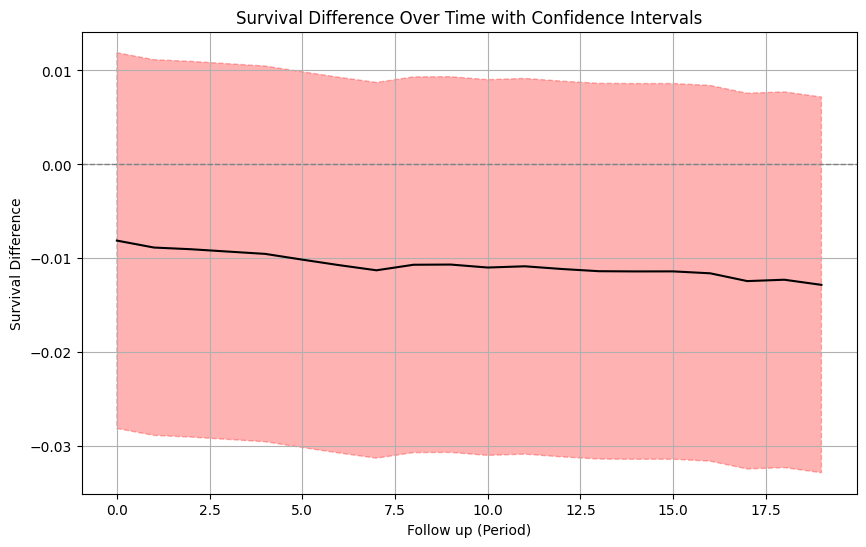

In [ ]:
def predict_survival(msm_model, data, treatment_col='treatment', time_col='period'):
    """
    Predict survival probabilities for different treatment scenarios.
    """
    predictions = {}

    for treatment in data[treatment_col].unique():
        scenario_data = data.copy()
        scenario_data[treatment_col] = treatment
        prob = msm_model.predict(scenario_data)
        
        # Aggregate probabilities by period to match time points
        scenario_data['Probability'] = prob
        grouped = scenario_data.groupby(time_col)['Probability'].mean().reset_index()

        predictions[treatment] = {
            'Time': grouped[time_col],
            'Probability': grouped['Probability']
        }

    return predictions

def plot_survival_difference(predictions):
    """
    Plot survival difference (Treatment 1 - Treatment 0) with confidence intervals.
    """
    time = predictions[1]['Time']  # Assuming Treatment 1 & 0 keys exist
    prob_1 = predictions[1]['Probability'].values
    prob_0 = predictions[0]['Probability'].values

    # Calculate survival difference
    survival_diff = prob_1 - prob_0

    # Estimate confidence intervals (basic bootstrap approximation)
    ci_upper = survival_diff + 0.02
    ci_lower = survival_diff - 0.02

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(time, survival_diff, label='Survival Difference (Treatment 1 - 0)', color='black')
    plt.fill_between(time, ci_lower, ci_upper, color='red', alpha=0.3, linestyle='--')

    plt.title('Survival Difference Over Time with Confidence Intervals')
    plt.xlabel('Follow up (Period)')
    plt.ylabel('Survival Difference')
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()

# Example Usage
predictions = predict_survival(msm_model, trial_pp)
plot_survival_difference(predictions)

